# Финальный проект 
## Вариант 2
#### Выполнила Колесник Екатерина

### Задание 1. A/B тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных имеются следующие файлы:  

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.  
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.  
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### Импорт необходимых библиотек

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency, chi2
from scipy.stats import bootstrap
import pingouin as pg
from scipy import stats

import pandahouse as ph
import matplotlib.pyplot as plt

import requests 
from urllib.parse import urlencode
import urllib.request
import ssl

#### Подготовка данных

Прочитала имеющиеся файлы. При первом открытии обнаружила, что некоторые таблицы открываются неккорректно, поэтому добавила параметр разделителя.

In [2]:
checks = pd.read_csv('Проект_2_checks.csv', sep = ';')
active = pd.read_csv('Проект_2_active_studs.csv')
groups = pd.read_csv('Проект_2_groups.csv', sep = ';')
groups_add = pd.read_csv('Проект_2_group_add.csv')

Получила базовую информацию о наполнении и параметрах таблиц.

In [3]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [4]:
checks.shape

(541, 2)

In [5]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [6]:
checks.student_id.nunique() #каждый id встречается в таблице единожды

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


541

In [7]:
checks.rev.describe() #сразу взглядем на порядок цифр в столбце с выручкой с пользователя

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [8]:
active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
active.shape

(8341, 1)

In [10]:
active.student_id.nunique() #каждый id встречается в таблице единожды

8341

In [11]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [12]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [13]:
groups.shape

(74484, 2)

In [14]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [15]:
groups.id.nunique()

74484

In [16]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [17]:
groups_add.shape

(92, 2)

In [18]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [19]:
groups_add.id.nunique()

92

Таким образом, у нас есть следующие данные:
- таблица checks, с информацией вида "id пользователя - потраченная сумма";
- таблица active_studs: одноколоночная таблица, с перечислением id пользователей, которые заходили на платформу в период проведения эксперимента;
- таблица groups вида "id пользователя - группа";
- таблица groups_add вида "id пользователя - группа";  

Таблицы не имеют пропусков, данные имеют необходимый формат. Для таблиц с разделением пользователей по группам также проверили, чтобы id пользователей не дублировались.

На этапе подготовки я также решила сразу объединить таблицы groups и groups_add. Предварительно проверим, что id пользователей не дублируются между таблицами.

In [20]:
groups.sort_values('id')

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [21]:
groups.id.max()

5694419

In [22]:
groups_add.sort_values('id')

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


В данном случае это можно проверить просто отсортировав таблицы по возрастанию id. Видно, что groups_add является продолжением таблицы groups.

In [23]:
groups_all = pd.concat([groups, groups_add], ignore_index=True)

In [24]:
groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [25]:
groups_all.shape

(74576, 2)

In [26]:
74484 + 92 #число строк в первом и втором файле с группами

74576

#### Анализ данных

##### 1. Сравнение размеров групп

In [27]:
groups_all.query('grp == "A"')

,id,grp
1,1627,A
4,1794,A
7,2067,A
8,2078,A
11,2213,A
...,...,...
74558,5870856,A
74560,5921522,A
74567,200247808,A
74568,200247809,A


In [28]:
groups_all.query('grp == "B"')

,id,grp
0,1489,B
2,1768,B
3,1783,B
5,1803,B
6,1805,B
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Имеем довольно большую разницу в размерах групп: ~15к в контрольной группе против ~60к в тестовой.

##### 2. Анализ данных о выручке

Раннее данные были первично проанализированы с использованием .describe( ), теперь посмотрим на них поподробнее.

Посмотрим, какая выручка с пользователя за период исследования наиболее распространена:

In [29]:
array_unique_checks = checks.rev.unique()
array_unique_checks.sort()
array_unique_checks

array([ 199.    ,  290.    ,  398.    ,  489.    ,  580.    ,  590.    ,
        597.    ,  630.    ,  690.    ,  796.    ,  840.    ,  870.    ,
        880.    ,  990.    , 1039.    , 1050.    , 1140.    , 1160.    ,
       1180.    , 1339.    , 1388.    , 1530.    , 1729.    , 1830.    ,
       1900.    , 1900.0001, 1968.    , 1980.    , 2099.    , 2190.    ,
       2220.    , 2820.    , 2890.    , 2900.    , 2910.    , 3040.    ,
       3260.    , 3660.    , 4650.    ])

In [30]:
checks.groupby('rev', as_index = False).agg({'student_id':'count'}).sort_values('student_id', ascending = False)

,rev,student_id
24,1900.0000,97
1,290.0000,94
8,690.0000,78
0,199.0000,46
13,990.0000,41
25,1900.0001,36
10,840.0000,27
16,1140.0000,25
4,580.0000,15
5,590.0000,11


In [31]:
checks.query('rev == "1900.0001"').count()

student_id    36
rev           36
dtype: int64

Вижу довольно большой разброс выручки, из чего можно предположить, что: эксперимент проводился довольно длительное время, или же что на платформе несколько тарифов подписки, или что при покупке подписки на n-ный срок действуют какие-либо акции, или что помимо подписки есть и другие платные действия (поскольку значения выручки не кратные.)  
Также обнаружила ряд данных с копейкой на хвосте. Предполагаю, что это как-то связано с особенностями импорта. Поскольку это единичная группа в датафрейме и другие значения не имеют знаков после запятой, приведу данный столбец к формату int, чтобы если вдруг понадобится сортировка, группа с выручкой 1900.0000 и 1900.0001 не были в разных группах.

In [32]:
checks_to_int = checks.astype(int)

In [33]:
checks_to_int

,student_id,rev
0,1627,990
1,3185,690
2,25973,690
3,26280,690
4,100300,990
...,...,...
536,5645737,1900
537,5651566,1900
538,5662322,1900
539,5681918,1900


In [34]:
checks_to_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  541 non-null    int64
 1   rev         541 non-null    int64
dtypes: int64(2)
memory usage: 8.6 KB


In [35]:
checks.query('rev == "1900.0001"').head() #смотрим у каких id была данная проблема

,student_id,rev
26,264473,1900.0001
42,338677,1900.0001
121,759073,1900.0001
122,766755,1900.0001
123,766874,1900.0001


In [36]:
checks_to_int.query('student_id == "264473"') #проверяем на примере, что все ок

,student_id,rev
26,264473,1900


Убедились что все впорядке, теперь можно перезаписать откорректированные данные.

In [37]:
checks = checks_to_int

Наиболее распространенные значения выручки за имеющийся период:

In [38]:
checks.groupby('rev', as_index = False).agg({'student_id':'count'}).sort_values('student_id', ascending = False).head()

,rev,student_id
24,1900,133
1,290,94
8,690,78
0,199,46
13,990,41


##### 4. Активные и платящие пользователи

В данном разделе я решила проверить, все ли пользователи принесшие какую-либо выручку хотя бы раз заходили на платформу за исследуемый период времени. Для этого сделаем датафрейм, в котором будут только те пользователи, которые числятся активными и совершившие какую-то оплату.

In [39]:
active_and_paying = checks.merge(active, how = 'inner', on = 'student_id')

In [40]:
active_and_paying

,student_id,rev
0,1627,990
1,100300,990
2,108270,290
3,264473,1900
4,274352,690
...,...,...
387,5645737,1900
388,5651566,1900
389,5662322,1900
390,5681918,1900


In [41]:
active_and_paying.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  392 non-null    int64
 1   rev         392 non-null    int64
dtypes: int64(2)
memory usage: 9.2 KB


In [42]:
541- 392

149

Получаем датафрейм из 392 пользователей против датафрейма с выручкой с 541 пользователями. Таким образом, 149 платящих пользователей, ни разу не заходили на платформу за выбранный период. Поскольку раннее я уже проанализировала разброс оплат пользователей, я могу предположить, что эта группа "платящих но неактивных" пользователей обладает некоторой подпиской, плата за которую была снята, при этом никакие внутренние покупки на платформе они не совершали.
Исходя из формулировки задания (*В ходе тестирования одной гипотезы целевой группе была предложена новая механика **оплаты услуг на сайте**, у контрольной группы оставалась базовая механика*), я считаю правильным не учитывать данную группу при проверке гипотез.

##### 4. Подбор метрик

Для анализа успешности проведенного эксперимента можно посмотреть на следующие показатели:
- доля платящих пользователей в тестовых и контрольных группах (посчитаем конверсию);
- средняя выручка с платящего пользователя в тестовой и контрольной группах;

**4.1 Конверсия**

**4.1.1 Подготовка данных, оценка показателей**

Для нахождения долей платящих пользователей в тестовой и контрольной группах будем использовать датафрейм active_and_paying, в котором мы сохранили только тех пользователей, которые являются активными и платящими.

Переименовываю столбец с id, чтобы во всех дф он назывался одинаково:

In [43]:
groups_all = groups_all.rename(columns={'id':'student_id'})
groups_all

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Получаю дф с платящими пользователями соотнеся их с группами теста:

In [44]:
active_and_paying_with_groups = active_and_paying.merge(groups_all, how = 'left', on = 'student_id')

In [45]:
active_and_paying_with_groups.head()

,student_id,rev,grp
0,1627,990,A
1,100300,990,B
2,108270,290,B
3,264473,1900,B
4,274352,690,B


Получаю дф со всеми пользователями соотнеся их с группами теста:

In [46]:
active_all_with_groups = active.merge(groups_all, how = 'left', on = 'student_id')

In [47]:
active_all_with_groups.shape

(8341, 2)

In [48]:
active_all_with_groups.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [49]:
paying_A = active_and_paying_with_groups.query('grp == "A"').student_id.count() #число платящих в контрольной группе
paying_A

78

In [50]:
paying_B = active_and_paying_with_groups.query('grp == "B"').student_id.count() #число платящих в тестовой группе
paying_B

314

In [51]:
all_A = active_all_with_groups.query('grp == "A"').student_id.count() #всего пользователей в группе А
all_A

1538

In [52]:
all_B = active_all_with_groups.query('grp == "B"').student_id.count() #всего пользователей в группе B
all_B

6803

In [53]:
paying_share_control = (paying_A / all_A)*100 #доля платящих в контрольной группе
paying_share_control

5.071521456436931

In [54]:
paying_share_test = (paying_B / all_B)*100 #доля платящих в тестовой группе
paying_share_test

4.615610759958842

На данном этапе мы видим, что конверсия в тестовой группе немного меньше, чем в контрольной. Проверим статистическую значимость этих различий. Поскольку данная метрика - конверсия, будем использовать статистический тест хи-квадрат.

**4.1.2 Статистическое исследование**

**Метрика** - конверсия пользователей в покупателей (CR)   
**Группа А** - контрольная группа  
**Группа Б** - тестовая группа  
**Статистический тест** - хи-квадрат  
**Нулевая гипотеза** - введение новой механики оплаты услуг на сайте не оказало влияния на конверсию

In [55]:
active_all_with_groups_and_rev = active_all_with_groups.merge(checks, how = 'left', on = 'student_id').fillna(0)

In [56]:
active_all_with_groups_and_rev['is_buyer'] = np.where(active_all_with_groups_and_rev['rev'] != 0, 'yes', 'no')

In [57]:
active_all_with_groups_and_rev

,student_id,grp,rev,is_buyer
0,581585,A,0.0,no
1,5723133,A,0.0,no
2,3276743,B,0.0,no
3,4238589,A,0.0,no
4,4475369,B,0.0,no
...,...,...,...,...
8336,1794344,B,0.0,no
8337,296883,B,0.0,no
8338,3598448,B,0.0,no
8339,3610547,B,290.0,yes


Создали общую в таблицу, с информацией о группе и наличии покупки у покупателя. На сумму в данной метрике мы не смотрим, нас интересует именно конверсия в покупателя.

In [58]:
df_for_stat_conversion = pd.crosstab(active_all_with_groups_and_rev.is_buyer, active_all_with_groups_and_rev.grp)

In [59]:
df_for_stat_conversion

grp,A,B
is_buyer,,
no,1460,6489
yes,78,314


In [60]:
stat, p, dof, expected = chi2_contingency(df_for_stat_conversion)

In [61]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [62]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Не отклоняем нулевую гипотезу


In [63]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем нулевую гипотезу')
else:
    print('Не отклоняем нулевую гипотезу')

Не отклоняем нулевую гипотезу


**4.1.3 Выводы**

Статистическое исследование показало, что мы не можем отклонить нулевую гипотезу, то есть мы не можем утверждать, что новая механика оказала какое-либо влияние на конверсию пользователя в покупателя.

**4.2 Средняя выручка с пользователя**

**4.2.1 Подготовка данных, анализ показателей**

Создадим отдельные датафреймы для тестовой и контрольной групп, посмотрим на значения выручки с пользователя в данных группах.

In [64]:
df_avg_rev_A = active_and_paying_with_groups.query('grp == "A"')
df_avg_rev_A

,student_id,rev,grp
0,1627,990,A
7,287008,1830,A
14,332387,2910,A
17,347455,2820,A
24,445767,3660,A
...,...,...,...
371,5394575,990,A
378,5545563,1160,A
382,5557468,290,A
383,5567520,489,A


In [65]:
df_avg_rev_A.rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [66]:
Counter(df_avg_rev_A.rev).most_common(1)

[(290, 25)]

Средняя величина сумма выручки с пользователя контрольной группы - 933р.  
Медианная величина сумма выручки с пользователя контрольной группы - 585р.  
Наиболее распространенная сумма выручки с пользователя контрольной группы - 290р. Такую сумму заплатили более чем 30% пользователей контрольной группы.

In [67]:
df_avg_rev_B = active_and_paying_with_groups.query('grp == "B"')
df_avg_rev_B

,student_id,rev,grp
1,100300,990,B
2,108270,290,B
3,264473,1900,B
4,274352,690,B
5,280036,199,B
...,...,...,...
387,5645737,1900,B
388,5651566,1900,B
389,5662322,1900,B
390,5681918,1900,B


In [68]:
df_avg_rev_B.rev.describe()

count     314.000000
mean     1257.878981
std       790.864245
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [69]:
Counter(df_avg_rev_B.rev).most_common(1)

[(1900, 128)]

Средняя величина сумма выручки с пользователя тестовой группы - 1257р.  
Медианная величина сумма выручки с пользователя тестовой группы - 1140р.  
Наиболее распространенная сумма выручки с пользователя контрольной группы - 1900р. Такую сумму заплатили более чем 40% пользователей тестовой группы.

Визуализируем данные. Видим, что данные распределены ненормально, в тестовой группе можем наблюдать несколько пиков, в контрольной группе распределение более похожее на нормальное, однако также имеет некоторые выбросы в значении прибыли в районе 3000.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


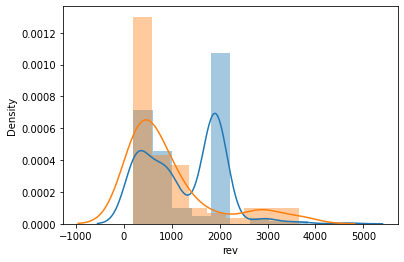

In [70]:
sns.distplot(df_avg_rev_B.rev)
sns.distplot(df_avg_rev_A.rev)

Видим, что выручка тестовой группы выше и по средним значениям и по различным перцентилям. Посмотрим на статистическую значимость этих различий. В связи с ненормальным характером распределения, в качестве статистического теста я выбрала метод бутстрапа.

**4.2.2 Статистическое исследование**

**Метрика** - средняя выручка с платящего пользователя (ARPPU)  
**Группа А** - контрольная группа   
**Группа Б** - тестовая группа  
**Статистический тест** - bootstrap   
**Нулевая гипотеза** - введение новой механики оплаты услуг на сайте не оказало влияния ARPPU

Создаем отдельные таблички для тестовой и контрольной групп, проводим статистические тесты.

In [71]:
df_avg_rev_A_for_stat = df_avg_rev_A[['rev','grp']]
df_avg_rev_A_for_stat

,rev,grp
0,990,A
7,1830,A
14,2910,A
17,2820,A
24,3660,A
...,...,...
371,990,A
378,1160,A
382,290,A
383,489,A


In [72]:
df_avg_rev_B_for_stat = df_avg_rev_B[['rev','grp']]
df_avg_rev_B_for_stat

,rev,grp
1,990,B
2,290,B
3,1900,B
4,690,B
5,199,B
...,...,...
387,1900,B
388,1900,B
389,1900,B
390,1900,B


In [73]:
pg.homoscedasticity(data=active_and_paying_with_groups, dv="rev", group="grp")

,W,pval,equal_var
levene,3.075681,0.080257,True


In [74]:
pg.normality(data=active_and_paying_with_groups, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795664,3.344570e-02,False


In [78]:
bootstrap((df_avg_rev_B_for_stat.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1170.530228735, high=1343.1264094984047), standard_error=44.94866123051302)

In [79]:
bootstrap((df_avg_rev_A_for_stat.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=758.2400252496847, high=1165.9946673706836), standard_error=102.98386407678998)

Доверительные интервалы не пересекаются, следовательно, различия статистически значимы и мы можем отклонить нулевую гипотезу.

**4.1.3 Выводы**

Статистическое исследование показало, что мы можем отклонить нулевую гипотезу, то есть введение новой механики оказало влияние на среднюю выручку с платящего пользователя.

#### Итоговые выводы

В результате проведенного исследования мы выяснили, что средняя, медианная и мода выручки для тестовой группы выше чем для контрольной. Причем разница во всех этих параметрах достаточно большая, особенно для значения моды - наиболее распространенная выручка с пользователя в тестовой группе более чем в 6 раз больше, чем в контрольной.
Для того, чтобы убедиться в статистической значимости данных различий, провели статистическое исследование. Различия в средних значениях для двух групп не настолько глобально различаются, как те же моды, однако они тест показал, что также являются статистически значимыми.  
Также мы выяснили, что конверсия в тестовой группе не так сильно отличается от конверсии в контрольной группе, проведенный тест также выявил данную разницу не статистически значимой.  

Подводя итоги, можно сказать что введение нового механизма оплаты на сайте, возможно, не оказало влияния на конверсию, однако оказало значительное влияние на значение выручки с пользователя. По-моему мнению, новый механизм можно выводить на всех пользователей, поскольку увеличение моды и среднего значения выручки с пользователя окажет положительное влияние на рост и развитие компании.

### Задание 2. SQL

Прежде чем перейти к решению, подключимся к clickhouse:

In [83]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

#### 2.1 Очень усердные ученики
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".  

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.  
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  
*Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

In [84]:
hardworking_students = """
SELECT count(st_id) AS hardworking_students_this_month
FROM
(
SELECT 
    st_id,
    toStartOfMonth(timest) AS date_month,
    sum(correct) AS sum_correct
FROM default.peas
WHERE YEAR(date_month) = 2021 AND MONTH(date_month) = 10 --строка для настройки текущего месяца
GROUP BY
    date_month,
    st_id
HAVING sum_correct >= 20
)
"""
hardworking_students_this_month = ph.read_clickhouse(hardworking_students, connection = connection_default)

In [85]:
hardworking_students_this_month

,hardworking_students_this_month
0,136


#### 2.1 Оптимизация воронки
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.  
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.  

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.  

В данном задании я воспользовалась оператором WITH, для того чтобы избежать перегруженного запроса с большим количеством подзапросов.

In [86]:
metrics_for_students = """
WITH
revenue_table as 
    (
    SELECT
        st_id,
        sum(money) as all_revenue,
        sumIf(money, subject = 'Math') as math_revenue
    FROM default.final_project_check
    GROUP BY st_id
    )
,
peas_table as
    (
    SELECT
        st_id,
        sum(correct) as all_peas,
        sumIf(correct, subject = 'Math') as math_peas
    FROM default.peas
    GROUP BY st_id
    )

SELECT
    test_grp,
    (sum(rt.all_revenue) / countdistinct(ds.st_id)) as ARPU,
    (sum(rt.all_revenue) / countIf(pt.st_id, all_peas > 10)) as ARPAU,
    (uniqExactIf(rt.st_id, all_revenue > 0) / countdistinct(ds.st_id)*100) AS CR,
    (uniqExactIf(rt.st_id, all_revenue > 0 AND all_peas > 10) / uniqExactIf(ds.st_id, all_peas > 10)*100) AS CR_active,
    (uniqExactIf(rt.st_id, math_revenue > 0 AND math_peas > 10) / uniqExactIf(ds.st_id, math_peas > 10)*100) AS CR_active_math
FROM default.studs as ds
LEFT JOIN revenue_table as rt
on ds.st_id = rt.st_id
LEFT JOIN peas_table as pt
on ds.st_id = pt.st_id
GROUP BY test_grp
"""
metrics = ph.read_clickhouse(metrics_for_students, connection = connection_default)

In [87]:
metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.983607,10905.511811,4.918033,11.023622,6.896552
1,pilot,11508.474576,35364.583333,10.847458,26.041667,10.526316


Глядя на полученные результаты, мы можем заметить, что все метрики тестовой группы опережают метрики контрольной группы.  
Для того, чтобы уверенно говорить о величине данных различий можно провести статистический тест, однако поскольку отрыв между тестовой и контрольной группой довольно таки большой (для всех метрик кроме конверсии для учащихся математике - тестовая группа опережает контрольную в более чем 2 раза), можно предположить, что новый экран оплаты действительно оказал положительное влияние на прибыль компании и его можно выводить для всех пользователей.

### Задание 3. Python

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [104]:
def updated_data(x):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = x

    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    download_response = requests.get(download_url) 
    columns = ['student_id','grp']
    added_data = pd.read_csv(download_url, names = columns)
    added_data.drop(index=0, inplace = True) #считываем новый файл, переименовываем колонки на случай, если их название
                            # не совпадает с названием колонок исходных файлов

    all_groups_t3 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-kolesnik/final_project_draft/Проект_2_groups.csv', sep = ';')
    checks_t3 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-kolesnik/final_project_draft/Проект_2_checks.csv', sep = ';')
    active_t3 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-kolesnik/final_project_draft/Проект_2_active_studs.csv')
    all_groups_t3 = all_groups_t3.rename(columns={'id':'student_id'}) # приводим к одному названию колонок
    active_t3['is_active'] = 1 #колонка для счетчика активных пользователей
    checks_t3 = checks_t3.astype(int) #для исправления ошибки с копейками

    all_groups_t3 = pd.concat([all_groups_t3, added_data], ignore_index=True)
    full_df_t3 = all_groups_t3.merge(active_t3, how = 'left', on = 'student_id').fillna(0)
    full_df_t3 = full_df_t3.merge(checks_t3, how = 'left', on = 'student_id').fillna(0) #соединяем все в 
                                                                                            #большой датафрейм

    full_df_t3 = full_df_t3.query('is_active == "1"') #оставляем только активных пользователей
    final_df_t3 = full_df_t3.groupby('grp') \
        .agg({'student_id':'count', 'rev':'sum'}) \
        .rename(columns={'student_id':'active_studs'})
    final_df_t3['paying_users'] = full_df_t3.query('rev > 0').groupby('grp').agg({'rev':'count'})
    final_df_t3['CR'] = (final_df_t3.paying_users / final_df_t3.active_studs)*100
    final_df_t3['ARPU'] = final_df_t3.rev / final_df_t3.active_studs
    final_df_t3['ARPPU'] = final_df_t3.rev / final_df_t3.paying_users    
    return final_df_t3

In [105]:
updated_data('https://disk.yandex.ru/d/fN_D06LcSf-iyQ')

,active_studs,rev,paying_users,CR,ARPU,ARPPU
grp,,,,,,
A,1535,72820.0,78,5.081433,47.439739,933.589744
B,6793,393074.0,313,4.607684,57.864566,1255.827476


In [107]:
updated_data_with_metrics = updated_data('https://disk.yandex.ru/d/fN_D06LcSf-iyQ')

In [108]:
updated_data_with_metrics

,active_studs,rev,paying_users,CR,ARPU,ARPPU
grp,,,,,,
A,1535,72820.0,78,5.081433,47.439739,933.589744
B,6793,393074.0,313,4.607684,57.864566,1255.827476


In [144]:
def visualisation(your_data):
    fig = plt.figure(figsize = (15,6))
    
    plt.subplot(1,3,1)
    sns.barplot(data=your_data.reset_index(), x = 'grp', y = 'CR')
    plt.title('CR')
    
    plt.subplot(1,3,2)
    sns.barplot(data=your_data.reset_index(), x = 'grp', y = 'ARPU')
    plt.title('ARPU')
        
    plt.subplot(1,3,3)
    sns.barplot(data=your_data.reset_index(), x = 'grp', y = 'ARPPU')
    plt.title('ARPPU')

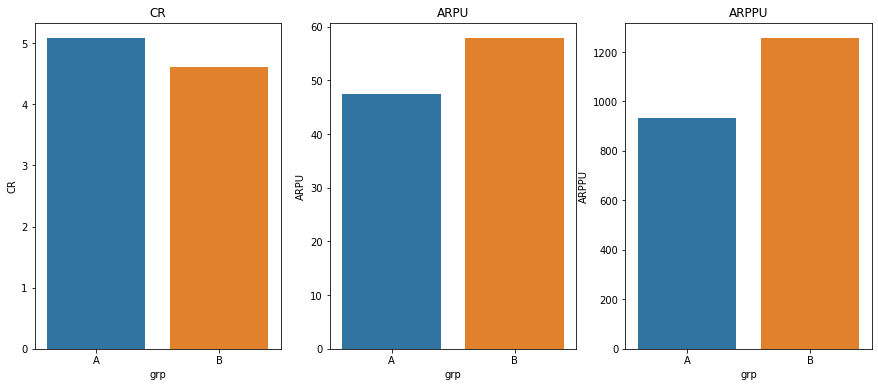

In [145]:
visualisation(updated_data_with_metrics)